This notebook is based on code written by:

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA

# Handwriting Recognision Example

In this part we use a dataset from sklearn consisting of a number of handwritten digits. The digits were drawn on an 8 by 8 pixel image. These images were then flattened to become a 1 by 64 digit array. In the dataset, there are 1797 indivdual pieces of data which can be digits between 0 and 9.

For the purposes of this task, we can think of each digit as being a point in "digit" space. To be able to differentiate between new data, i.e. a new handwritten digit, we could see where the new digit is in digit space and give it the value of the nearest neighbour point in digit space. As the data we have consists of several variations of the same digit, then in digit space, we expect to have clumps corresponding to different digits.

Without further pre-processing, we would need to work in the 64 dimensional space which can be challanging computationally and conceptually. Using PCA, we can reduce the number of dimensions needed to represent each digit remedying these challanges. 

## Examining at the data

Before we attempt to utilise the data, we first look to understand what the data represents.

The data is imported from sklearn

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

An example of a digit is shown below. It is an array containing 64 values. Each value represents the colour of a pixel. The values are a range of integers from 0 (white) to 16 (black). 

In [3]:
print(digits.data[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


Which digit does this represent? Each piece of data is labelled by which digit it is represening. The digit above is representing: 

In [4]:
digits.target[0]

0

It is a bit of a challange visualising this data as 64 dimensions is a lot to comprehend. One way of visualising the data is by plotting the a single component of each digit.

In [5]:
comp = 2 # the component we wish to visualise

Below, the values of digits at a certain dimension are given. Transarency is used to show how popular each value is. The values correspond to the colour of digit at that point. The darkest colour is 16, the lightest is 0.

Text(0, 0.5, 'Values')

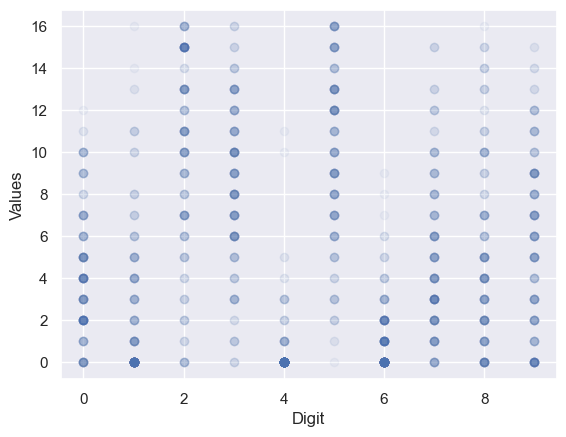

In [6]:
plt.scatter(digits.target, digits.data[:, comp], alpha=0.05)
plt.xlabel("Digit")
plt.ylabel("Values")

From this plot, we can see that there are only integer values for each digit. we can also see differences in variation, mean, and mode for each digit. For example. the digit 4 has a much smaller variation than the digit 3. The digit 4 and the digit 1 both often white at this dimension, i.e. there the stroke in the handwriting does not go past this cell very often. On the other hand, the digit 2 often has some part of the stroke going through this dimension.

Below, we plot the first 10 digits.

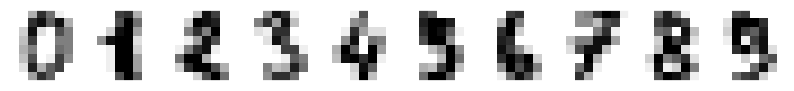

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.data[i].reshape(8, 8),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))


Now, we plot the 2nd component of each of the first 10 digits:

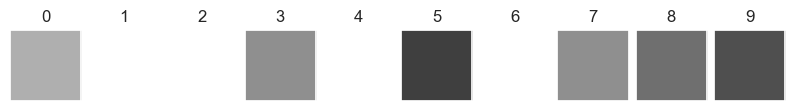

In [8]:
def plot_digits_part(data):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i][comp].reshape(1,1),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
        ax.set_title(i)
plot_digits_part(digits.data)

It is observed that there is a large disparity in each of the digits at this pixel, however we cant distinguish many of the digits. For example, 1, 2, 4 and 6 are all represented by the same colour.

To get a better feel for each digit at this pixel, we can also average the data for each digit.

In [9]:
digit_parts = np.zeros(10) # sum of values
digit_parts_num = np.zeros(10) # number of values
for i, digit_part in enumerate(digits.data[:,comp]):
    digit_parts[digits.target[i]] += digit_part
    digit_parts_num[digits.target[i]] += 1
digit_parts_ave = np.zeros(10) # average value for particular dimension of digit
for i, part in enumerate(digit_parts):
    digit_parts_ave[i] = part/digit_parts_num[i]
print(digit_parts_ave)

[4.18539326 2.45604396 9.66666667 8.38797814 0.45303867 9.98351648
 1.13812155 5.10055866 5.02298851 5.68333333]


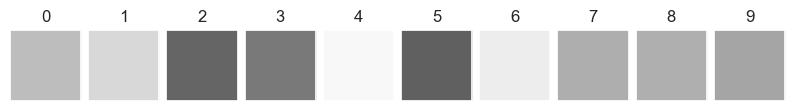

In [10]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digit_parts_ave[i].reshape(1,1),
              cmap='binary', interpolation='nearest',
              clim=(0, 16))
    ax.set_title(i)


Still, there is a large amount of disparity, however there are still some digits which appear very similar e.g. 7 and 8 or 2 and 5

So far, we have seen that a single component of the digit can have large disparity but is still not very accurate for distinguishing digits.

## Applying PCA

Applying PCA, we can find where the most variation is present in the data.

In [11]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [12]:
pca = PCA(64)  # We use 64 (the same number of dimesnions as the data) so that we can look at all components
projected = pca.fit_transform(digits.data) 
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 64)


Similar to the plot above, we can plot a single pixel of each digit to see how they differ. Here we plot the pixel with the strongest variation.

Text(0, 0.5, 'Values')

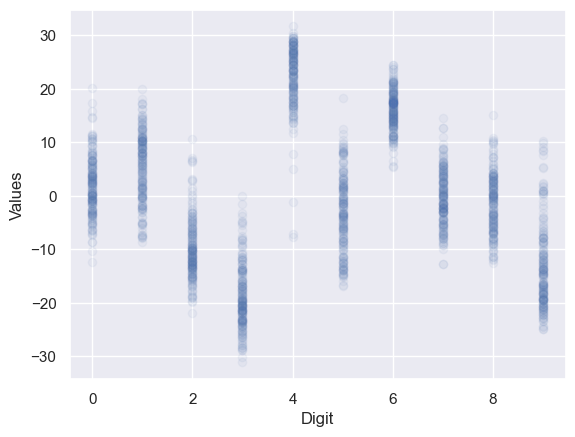

In [13]:
plt.scatter(digits.target, projected[:, 0], alpha=0.05)
plt.xlabel("Digit")
plt.ylabel("Values")

The most striking difference is that the data is now continuous rather than ingeral. Each has a different mean, mode, etc. This makes it better for differentiating. Not much better however.

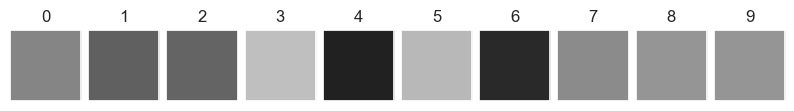

In [14]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i, 0].reshape(1,1),
              cmap='binary', interpolation='nearest',
              clim=(-32, 32))
    ax.set_title(i)
    
    

[  1.95636008   5.42842439  -9.81971244 -18.66467291  22.25344599
  -2.96751037  16.18325894  -0.17079401  -1.26672529 -13.04697483]


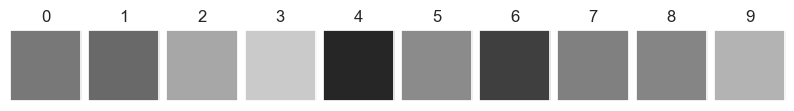

In [15]:
digit_parts = np.zeros(10) # sum of values
digit_parts_num = np.zeros(10) # number of values
for i, digit_part in enumerate(projected[:, 0]):
    digit_parts[digits.target[i]] += digit_part
    digit_parts_num[digits.target[i]] += 1
digit_parts_ave = np.zeros(10) # average value for particular dimension of digit
for i, part in enumerate(digit_parts):
    digit_parts_ave[i] = part/digit_parts_num[i]
print(digit_parts_ave)

fig, axes = plt.subplots(1, 10, figsize=(10, 1),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digit_parts_ave[i].reshape(1,1),
              cmap='binary', interpolation='nearest',
              clim=(-32, 32))
    ax.set_title(i)

The first two components of the PCA data is plotted to show that with two components, we can already differentiate many of the digits.

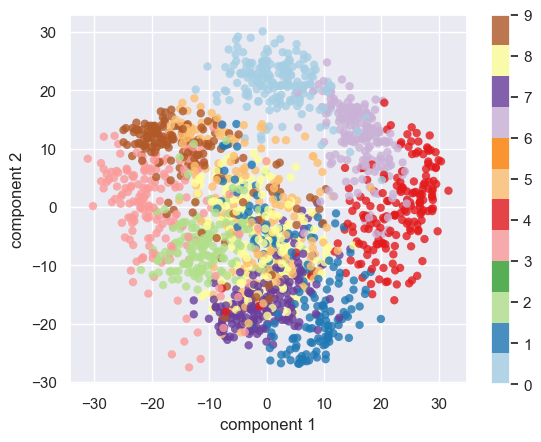

In [16]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.8,
            cmap='Paired')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();


Two later components are plotted to show that the later components contain less vairance.

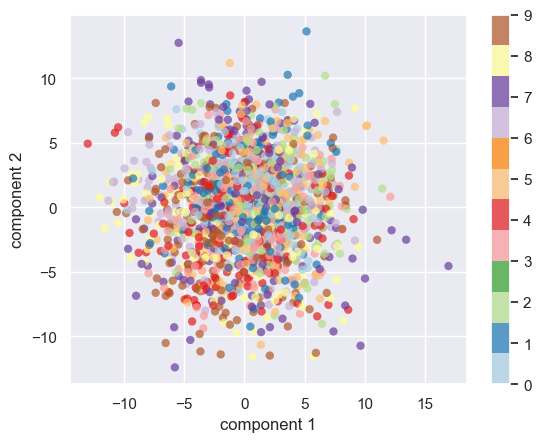

In [17]:
plt.scatter(projected[:, 16], projected[:, 17],
            c=digits.target, edgecolor='none', alpha=0.7,
            cmap='Paired') # spectral is not supported so used inferno
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

A scree plot to show when variance cuts of.

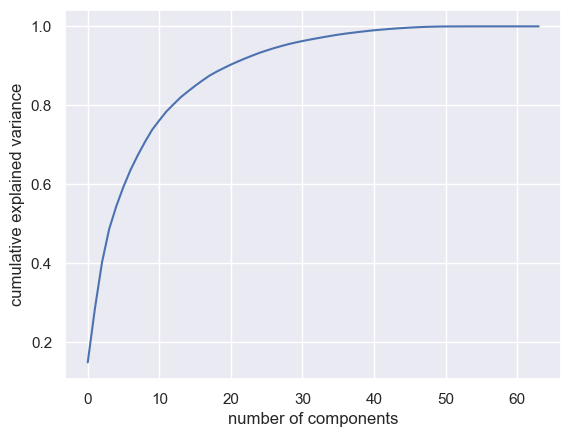

In [18]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

There is no clear elbow in the scree plot, but we can see that PCA can reduce the dimensionality well. With just 10 components, 74% of the variance is retained.

In [19]:
print("Explained variance in the first component:", pca.explained_variance_ratio_[0])
print("Explained variance in the first 10 components", sum(pca.explained_variance_ratio_[:10]))

Explained variance in the first component: 0.1489059358406381
Explained variance in the first 10 components 0.7382267688459531


## Effect of PCA

Before PCA us applied, the digits looked like this:

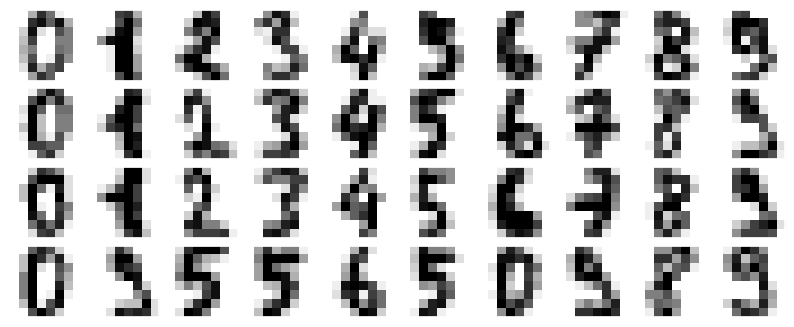

In [20]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

After PCA, taking the first 2 components

In [21]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
        ax.set_title(digits.target[i])

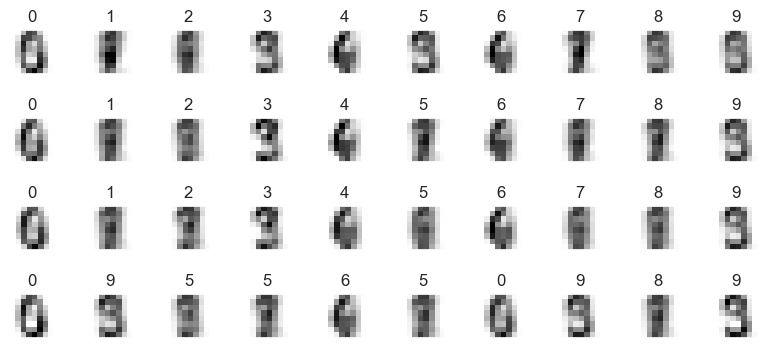

In [22]:
pca = PCA(2).fit(digits.data)
components = pca.transform(digits.data)
pca.n_components_
components_2 = pca.inverse_transform(components)
plot_digits(components_2)

Ten compoents

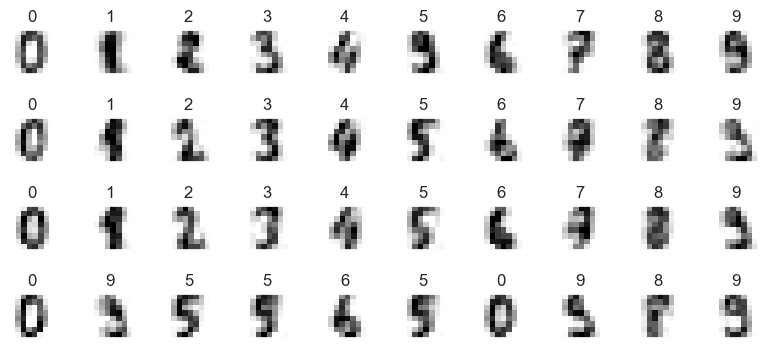

In [23]:
pca = PCA(10).fit(digits.data)
components = pca.transform(digits.data)
pca.n_components_
components_10 = pca.inverse_transform(components)
plot_digits(components_10)

## Noise Reduction

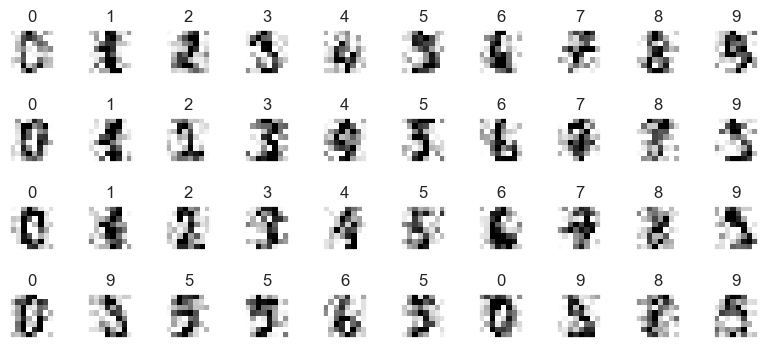

In [24]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

In [25]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

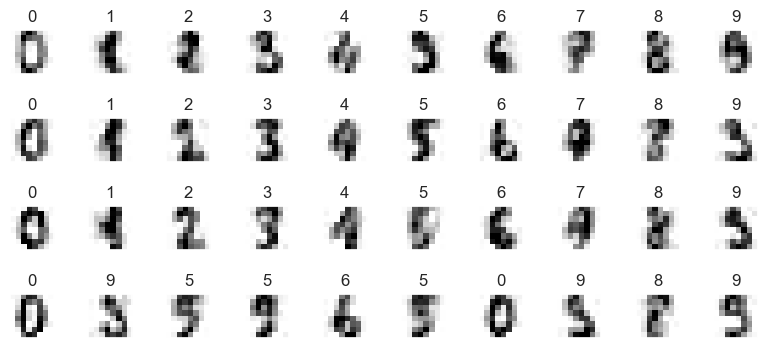

In [26]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)